# Build Comment Classifier

This notebook is to build the Stackoverflow comment classifier and output:
- `sentence_scorer.pkl` -> `SentenceScorer` to score a given list of processed comment text
- `comment_classifier.pkl` -> `BalancedRandomForestClassifier` Classifier model to predict whether comment is useful or not

## Imports and definitions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

from comment_classifier.sentence_scorer import SentenceScorer
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score,roc_auc_score,plot_confusion_matrix
import joblib

In [2]:
comments_model_input_df = pd.read_csv('data/classifier/comments_model_input.csv')

## Development

### Description

Pre-processing comment (`comment_classifier/utils`):
- Replace URLs, mentions and code
- Remove stopwords
- Remove special characters, except '?'
- Tokenize and apply stemming



Two-level Random forest classifier
1. **SentenceScorer**: Tf-idf of each word in sentence, generating a text score with the classifier probability prediction
2. **Comment classifier**: Uses the Sentence Score (first classifier), Sentence length and NLTK Text Sentiment to predict useful/not useful
    - Note: Using 3 main features from the model as described in page 20 of "Are comments on Stack Overflow well organized for easy retrieval by developers?" paper

### First level: SentenceScorer

In [3]:
filtered_data_df = comments_model_input_df[comments_model_input_df['CommentTextProc'].notnull()]

sss_half = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
X = filtered_data_df[['CommentTextProc','CommentTextLen','Sentiment']]
y = np.array(filtered_data_df['IsUsefulSum'])

sss_half.split(X, y)

<generator object BaseShuffleSplit.split at 0x7f9a6083b190>

In [4]:
filtered_data_df = comments_model_input_df[comments_model_input_df['CommentTextProc'].notnull()]
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3)
sss_half = StratifiedShuffleSplit(n_splits=1, test_size=0.5)

X_base = filtered_data_df[['CommentTextProc','CommentTextLen','Sentiment']]
y_base = np.array(filtered_data_df['IsUsefulSum'])

current_f1_score = 0
for first_half_index, second_half_index in sss_half.split(X, y):
    X, y = X_base.iloc[first_half_index], y[first_half_index]
    for train_index, test_index in StratifiedShuffleSplit(n_splits=5, test_size=0.1).split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        tf_idf = TfidfVectorizer()
        X_train_tf = tf_idf.fit_transform(X_train['CommentTextProc'])
        X_test_tf = tf_idf.transform(X_test['CommentTextProc'])

        brfc = BalancedRandomForestClassifier().fit(X_train_tf, y_train)
        scored_f1_score = f1_score(y_test,brfc.predict(X_test_tf))
        print("F1 Score for Balanced Random Forest Classifier is ", scored_f1_score)

        if scored_f1_score > current_f1_score:
            current_tf_idf = tf_idf
            current_f1_score = scored_f1_score
            current_model = brfc
            X_two, y_two = X_base.iloc[second_half_index], y_base[second_half_index]
            current_y_test = y_test
            current_X_train_tf = X_train_tf
            current_X_test_tf = X_test_tf
            current_y_train = y_test
        
y_predict = current_model.predict(current_X_test_tf)
print(f"\n\nF1 Score: {current_f1_score}")
print(f"Accuracy: {accuracy_score(current_y_test, y_predict)}")
print(f"Precision: {precision_score(current_y_test, y_predict)}")
print(f"Recall: {recall_score(current_y_test, y_predict)}")
print(f"AUC: {roc_auc_score(current_y_test, y_predict)}")

F1 Score for Balanced Random Forest Classifier is  0.8078431372549019
F1 Score for Balanced Random Forest Classifier is  0.7905138339920948
F1 Score for Balanced Random Forest Classifier is  0.8314606741573034
F1 Score for Balanced Random Forest Classifier is  0.8313725490196079
F1 Score for Balanced Random Forest Classifier is  0.7968127490039841


F1 Score: 0.8314606741573034
Accuracy: 0.7540983606557377
Precision: 0.9098360655737705
Recall: 0.7655172413793103
AUC: 0.738021778584392


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


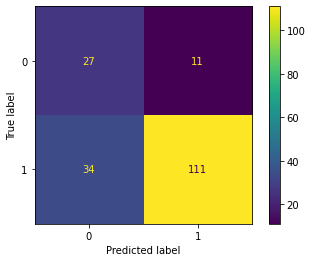

In [5]:
fig=plot_confusion_matrix(current_model, current_X_test_tf, current_y_test)
plt.show()

### Second level: Comment classifier

In [6]:
sentence_scorer = SentenceScorer(tf_idf_vectorizer=current_tf_idf, score_classifier_model=current_model)

In [7]:
features = ['TextScore', 'Sentiment', 'CommentTextLen']

f1_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
auc_scores = []

for train_index, test_index in sss.split(X, y):
    X_train_two, X_test_two = X_two.iloc[train_index], X_two.iloc[test_index]
    y_train_two, y_test_two = y_two[train_index], y_two[test_index]
    X_train_two['TextScore'] = sentence_scorer.get_scores(X_train_two['CommentTextProc'])
    X_test_two['TextScore'] = sentence_scorer.get_scores(X_test_two['CommentTextProc'])

    brfc = BalancedRandomForestClassifier().fit(X_train_two[features], y_train_two)

    y_predict = brfc.predict(X_test_two[features])

    accuracy_scores.append(accuracy_score(y_test_two, y_predict))
    precision_scores.append(precision_score(y_test_two, y_predict))
    recall_scores.append(recall_score(y_test_two, y_predict))
    f1_scores.append(f1_score(y_test_two,y_predict))
    auc_scores.append(roc_auc_score(y_test_two,y_predict))
    

print(f"\n\nAccuracy: {round(mean(accuracy_scores), 2)}")
print(f"Precision: {round(mean(precision_scores), 2)}")
print(f"Recall: {round(mean(recall_scores), 2)}")
print(f"F1 Score: {round(mean(f1_scores), 2)}")
print(f"AUC: {round(mean(auc_scores), 2)}")

<ipython-input-7-e1c77b292300>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_two['TextScore'] = sentence_scorer.get_scores(X_train_two['CommentTextProc'])
<ipython-input-7-e1c77b292300>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_two['TextScore'] = sentence_scorer.get_scores(X_test_two['CommentTextProc'])
<ipython-input-7-e1c77b292300>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste



Accuracy: 0.8
Precision: 0.94
Recall: 0.8
F1 Score: 0.86
AUC: 0.8


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


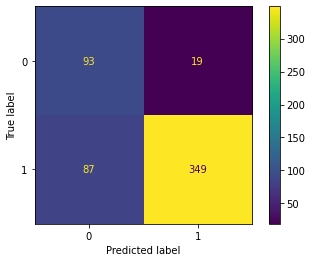

In [8]:
fig=plot_confusion_matrix(brfc, X_test_two[features], y_test_two)
plt.show()

### Save scorer and classifier

In [9]:
joblib.dump(sentence_scorer, 'sentence_scorer.pkl', compress=9)
joblib.dump(brfc, 'comment_classifier.pkl', compress=9)

['comment_classifier.pkl']